# Part 1 - DEFINE

### ---- 1 Define the problem ----

**Predict salary based on job descriptions including company id, job type, degree, major, industry, years of experience and proximity to metropolis. The objective is to predict salary as accurately as possible or deviate from the actual as small as possible**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from dython import nominal
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#programmer info here
__author__ = "Lin"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
#load the data into a Pandas dataframe
train_salaries= pd.read_csv('data/train_salaries.csv')
train_salaries.info()
train_salaries.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   jobId   1000000 non-null  object
 1   salary  1000000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 15.3+ MB


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [3]:
train_features= pd.read_csv('data/train_features.csv', sep=',')
train_features.info()
train_features.head()
train_features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


,yearsExperience,milesFromMetropolis
count,1000000.000000,1000000.000000
mean,11.992386,49.529260
std,7.212391,28.877733
min,0.000000,0.000000
25%,6.000000,25.000000
50%,12.000000,50.000000
75%,18.000000,75.000000
max,24.000000,99.000000


In [4]:
test_features= pd.read_csv('data/test_features.csv', sep=',')
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


### ---- 3 Clean the data ----
**join features and target variable to get a complete data set**

In [5]:
train_df = pd.merge(train_features, train_salaries, on = 'jobId')
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


**look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it**

In [6]:
# duplicate
print("There are {} duplicates in the training data set".format(train_df.duplicated().sum()))
# check invalid salaries
print(sum(train_df['salary']<=0))
# drop zero or negative salaries
train_df.drop(train_df[train_df.salary<=0].index, inplace=True)
print("Total of NAs are \n",train_df.isna().sum())

There are 0 duplicates in the training data set
5
Total of NAs are 
 jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64


### ---- 4 Explore the data (EDA) ----
**summarize count of categories**

In [7]:
#summarize each categorical feature variable
cat_header = ['companyId', 'jobType', 'degree', 'major','industry']
for i in cat_header:
    x = train_df[i].value_counts()
    print(i,"count is:\n",x)


companyId count is:
 COMP39    16193
COMP35    16114
COMP59    16066
COMP30    16041
COMP3     16028
          ...  
COMP17    15715
COMP0     15666
COMP2     15641
COMP8     15638
COMP57    15635
Name: companyId, Length: 63, dtype: int64
jobType count is:
 SENIOR            125886
VICE_PRESIDENT    125234
MANAGER           125120
CTO               125045
JANITOR           124971
CEO               124778
JUNIOR            124592
CFO               124369
Name: jobType, dtype: int64
degree count is:
 HIGH_SCHOOL    236975
NONE           236853
BACHELORS      175495
DOCTORAL       175362
MASTERS        175310
Name: degree, dtype: int64
major count is:
 NONE           532353
CHEMISTRY       58875
LITERATURE      58684
ENGINEERING     58594
BUSINESS        58518
PHYSICS         58410
COMPSCI         58382
BIOLOGY         58379
MATH            57800
Name: major, dtype: int64
industry count is:
 WEB          143205
AUTO         142941
FINANCE      142866
EDUCATION    142819
OIL          14277

In [8]:
# Unique values in train_df
train_df.nunique()

jobId                  999995
companyId                  63
jobType                     8
degree                      5
major                       9
industry                    7
yearsExperience            25
milesFromMetropolis       100
salary                    279
dtype: int64

**Data seem balanced**

**Correlation between features and target variable:**

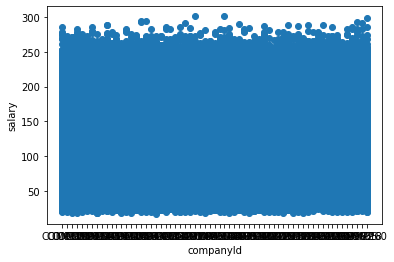

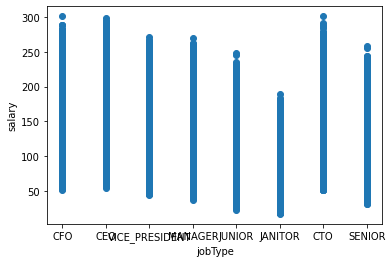

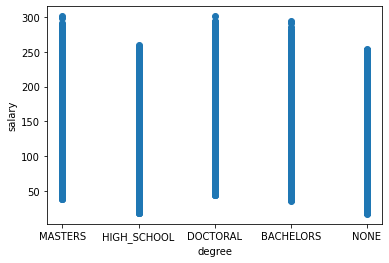

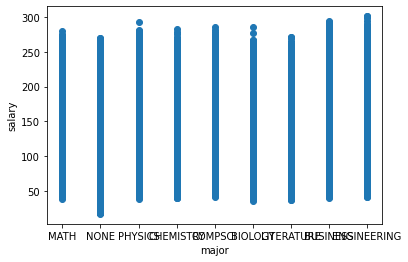

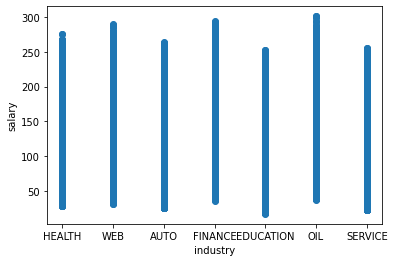

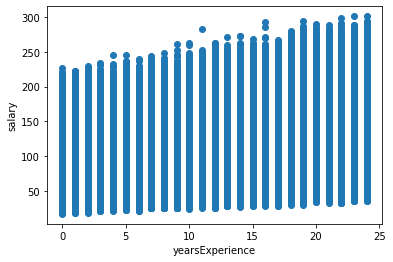

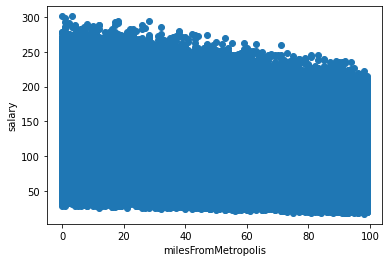

In [9]:
#look for correlation between each feature and the target
feature_header = cat_header+['yearsExperience', 'milesFromMetropolis']
for i in feature_header:
    fig, ax = plt.subplots()
    ax.scatter(train_df[i],train_df['salary'])
    ax.set_xlabel(i)
    ax.set_ylabel('salary')
    plt.show()

**The plots above show salary and company id are not related.**

In [10]:
cat_header.remove('companyId')
feature_header.remove('companyId')

**Correlation among features and target variable:**

In [11]:
# correlation among all
select_headers=feature_header+['salary']
train_df2 = train_df[select_headers]
train_df2.head()

,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,CFO,MASTERS,MATH,HEALTH,10,83,130
1,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [12]:
# subset categorical features
train_df2_cat = train_df2[cat_header]
train_df2_cat.head()
test_df_cat = test_features[cat_header]

/home/lin/.local/lib/python3.6/site-packages/pandas/core/frame.py:4323: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


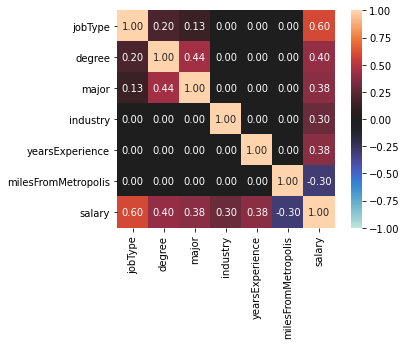

{'corr':                       jobType    degree     major  industry  yearsExperience  \
 jobType              1.000000  0.199119  0.133876  0.000940         0.001505   
 degree               0.199119  1.000000  0.444707  0.000259         0.000877   
 major                0.133876  0.444707  1.000000  0.000000         0.001192   
 industry             0.000940  0.000259  0.000000  1.000000         0.001871   
 yearsExperience      0.001505  0.000877  0.001192  0.001871         1.000000   
 milesFromMetropolis  0.002587  0.002094  0.002531  0.001487         0.000672   
 salary               0.597463  0.401300  0.378675  0.296626         0.375013   
 
                      milesFromMetropolis    salary  
 jobType                         0.002587  0.597463  
 degree                          0.002094  0.401300  
 major                           0.002531  0.378675  
 industry                        0.001487  0.296626  
 yearsExperience                 0.000672  0.375013  
 milesFromMetropol

In [13]:
# use nominal package to show correlation for all
nominal.associations(train_df2, nominal_columns=cat_header)

**It seems job type and degree are more positively correlated to salary than other variables while proximity to metropolis is negatively correlated to salary.**

**Major and degree are more correlated among features.**

### ---- 5 Establish a baseline ----
**Use a simple regression model, MSE as metrics, and 5-fold cross-validation. Select LASSO to potentially force some of the correlated feature coefficients to be zero**

In [14]:
# use one-hot encoding to convert categorical to numeric values, a prerequisite for regression
train_dummies = pd.get_dummies(data=train_df2_cat, drop_first=True)
train_temp = train_df2[['yearsExperience','milesFromMetropolis','salary']]
train_temp = pd.concat([train_temp, train_dummies], axis=1)

test_dummies = pd.get_dummies(data=test_df_cat, drop_first=True)
test_temp = test_features[['yearsExperience','milesFromMetropolis']]
test_df = pd.concat([test_temp, test_dummies], axis=1)
# prepare dataset for regression
train_salary = train_temp['salary']
train_features = train_temp.drop(columns='salary')

In [15]:
#Lasso as a baseline
lasso = Lasso(alpha=0.1)

In [16]:
# split dataset and set cross validation(cv) to be 5
X_train, X_test, y_train, y_test = train_test_split(train_features, train_salary, test_size=0.3, random_state=1)

In [17]:
# see model parameters
results = lasso.fit(X_train, y_train)
print('regression coefficients:', results.coef_)

regression coefficients: [ 2.00786493e+00 -3.99464106e-01 -3.33135470e+00 -3.36346013e+00
 -5.63129299e+01 -4.33211316e+01 -2.34244107e+01 -3.33207529e+01
 -1.34675053e+01  9.39685692e+00 -4.08340015e+00  4.42573678e+00
 -7.78816434e+00  3.64192977e+00 -0.00000000e+00  5.34764016e-03
  6.56147755e+00 -4.20051996e+00  1.23486916e+00 -8.98701219e+00
  0.00000000e+00 -1.07401349e+01  1.90613769e+01  4.09237341e+00
  1.91537630e+01 -5.65910864e+00  1.00178140e+01]


In [18]:
# run model and calculate negative MSE
cv_results = cross_val_score(lasso, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

In [19]:
# check MSE to see the baseline fit
print(abs(cv_results))
print("MSE: %0.2f (+/- %0.2f)" % (abs(cv_results.mean()), cv_results.std()*1.96))

[391.92989934 390.3662306  390.70010125 391.35696009 391.98530208]
MSE: 391.27 (+/- 1.27)


### ---- 6 Hypothesize solution ----

Brainstorm 3 models that may improve results over the baseline model based on the EDA and explain why they're reasonable solutions here.

Also write down any new features that I think I should try adding to the model based on my EDA, e.g. interaction variables, summary statistics for each group, etc

3 models:
1) Decision tree as it is able to capture non-linear relationships

2) Random forest that can capture many smaller decision trees to combine weak learners to a strong learner

3) XG boosting to learn sequentially from previous models that provides quick and effective ensemble

## Part 3 - DEVELOP

cycle through creating features, tuning models, and training/validing models (steps 7-9) until the efficacy goal is reached

#### use MSE as metric and the goal is:
**to have MSE<360**

### ---- 7 Engineer features  ----  

### ---- 8 Create models ----
**First with decision tree model**

In [20]:
#create and tune the models that you brainstormed during part 2

In [21]:
# decision tree
dt = DecisionTreeRegressor(max_depth=10, random_state=3)

In [22]:
# run model and calculate negative MSE
cv_results = cross_val_score(dt, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

In [23]:
# check MSE to see the decision tree fit
print(abs(cv_results))
print("MSE: %0.2f (+/- %0.2f)" % (abs(cv_results.mean()), cv_results.std()*1.96))

[490.167319   489.20280547 490.51974235 491.44822817 489.91027108]
MSE: 490.25 (+/- 1.45)


The decision tree model actually underperforms the baseline model. Perhaps random forest will help.

**Second with random forest**

In [24]:
# initialize random forest
rf = RandomForestRegressor(n_estimators = 200, max_features = 10, max_depth = 20, criterion='mse',
                           min_samples_split = 10, min_samples_leaf = 2, bootstrap = True, n_jobs=-1,
                           random_state = 42)

In [25]:
# run model and calculate negative MSE
cv_results = cross_val_score(rf, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

In [26]:
# check MSE to see the random forest fit
print(abs(cv_results))
print("MSE: %0.2f (+/- %0.2f)" % (abs(cv_results.mean()), cv_results.std()*1.96))

[373.16663266 372.91839252 372.93387374 373.78333419 374.91073189]
MSE: 373.54 (+/- 1.47)


Random forest model is marginally better than baseline but not by much. In addition, the calculation takes a long time (>5 mins).  

**Third with XGBoost on linear regression, this should improve on the baseline model.**

In [27]:
xgb_reg = xgb.XGBRegressor(learning_rate=0.2, max_depth=8, n_estimators=50, seed=123)

In [28]:
cv_results = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

In [29]:
# check MSE to see how much improvement XGBoost offers
print(abs(cv_results))
print("MSE: %0.2f (+/- %0.2f)" % (abs(cv_results.mean()), cv_results.std()*1.96))

[360.12876802 359.30780557 359.44908955 359.58413893 360.83963618]
MSE: 359.86 (+/- 1.10)


**XGBoost improves the baseline model by 8% on MSE.**

### ---- 9 Test models ----  
**First list MSE for the baseline lasso model**

In [31]:
# 5-fold cv measure of MSE negative MSE
cv_results_lasso = cross_val_score(lasso, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
# check MSE based on CV
print("Lasso MSE on CV: %0.2f" % (abs(cv_results_lasso.mean())))

Lasso MSE on CV: 391.27


In [32]:
# use lasso to fit test data
y_pred_lasso = lasso.predict(X_test) 
print('Lasso MSE on test data:', mean_squared_error(y_test, y_pred_lasso))

Lasso MSE on test data: 390.903503648066


**Second list MSE for the best model - XGBoost on regression**

In [33]:
# 5-fold cv measure of MSE negative MSE
cv_results_xgb = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
# check MSE based on CV
print("XGBoost MSE on CV: %0.2f" % (abs(cv_results_xgb.mean())))

XGBoost MSE on CV: 359.86


In [36]:
# Print accuracy score using 5-fold cv
scores = cross_val_score(xgb_reg, X_test, y_test, cv=5)
print("XGBoost 5-Fold CV Accuracy on test data:", (np.mean(scores)), (np.std(scores)))

XGBoost 5-Fold CV Accuracy on test data: 0.7585945431614401 0.001538986173732344


In [37]:
# use xgboost to fit test data in the training data set
xgb_reg.fit(X_train, y_train)
y_pred_xbg = xgb_reg.predict(X_test) 
print('XGBoost MSE on test data:', mean_squared_error(y_test, y_pred_xbg))


XGBoost MSE on test data: 359.9155065439011


### ---- 10 Select best model  ----

yearsExperience           0.021441
milesFromMetropolis       0.011224
jobType_CFO               0.002688
jobType_CTO               0.004695
jobType_JANITOR           0.566073
jobType_JUNIOR            0.068714
jobType_MANAGER           0.030298
jobType_SENIOR            0.049052
jobType_VICE_PRESIDENT    0.010587
degree_DOCTORAL           0.011701
degree_HIGH_SCHOOL        0.003527
degree_MASTERS            0.005900
degree_NONE               0.019022
major_BUSINESS            0.005192
major_CHEMISTRY           0.002048
major_COMPSCI             0.000892
major_ENGINEERING         0.006853
major_LITERATURE          0.003008
major_MATH                0.002960
major_NONE                0.079363
major_PHYSICS             0.001710
industry_EDUCATION        0.024512
industry_FINANCE          0.017828
industry_HEALTH           0.004855
industry_OIL              0.019239
industry_SERVICE          0.014910
industry_WEB              0.011707
dtype: float32


<AxesSubplot:>

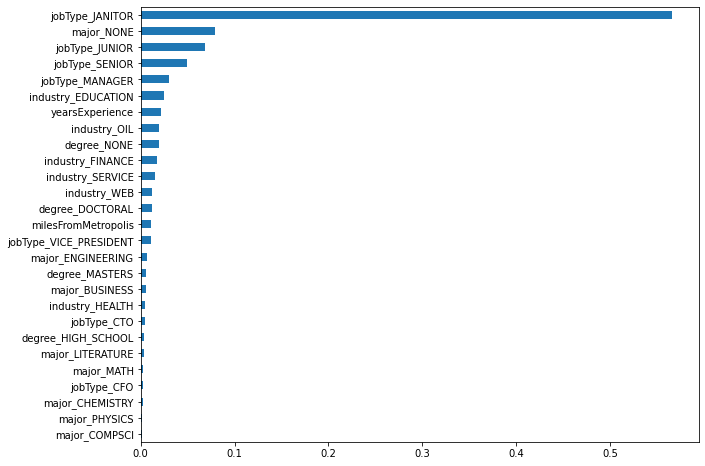

In [38]:
# select XGboost to be the best model and apply on the test dataset
y_pred_testdf = xgb_reg.predict(test_df)
feature_importances = pd.Series(xgb_reg.feature_importances_, index=test_df.columns)
print(feature_importances)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind='barh', figsize=(10,8))

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [39]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset
def salary_prediction_pipeline(train_feat, train_target, test_feat):
    
    #load data
    train_salaries= pd.read_csv(train_feat)
    train_features= pd.read_csv(train_target, sep=',')
    test_features= pd.read_csv(test_feat, sep=',')
    join_on = 'jobId'
    train_df = pd.merge(train_features, train_salaries, on = join_on)

    # drop zero or negative salaries
    train_df.drop(train_df[train_df.salary<=0].index, inplace=True)
    
    #summarize each categorical feature variable
    cat_header = ['jobType', 'degree', 'major','industry']
    num_header = ['yearsExperience', 'milesFromMetropolis']
    tar_header = ['salary']
    feature_header = cat_header+num_header 
    select_headers=feature_header+tar_header 

    #a clean dataset
    train_df2 = train_df[select_headers]

    # subset categorical features
    train_df2_cat = train_df2[cat_header]
    # use one-hot encoding to convert categorical to numeric values, a prerequisite for regression
    train_dummies = pd.get_dummies(data=train_df2_cat, drop_first=True)
    train_temp = train_df2[num_header+tar_header]
    train_temp = pd.concat([train_temp, train_dummies], axis=1)

    test_df_cat = test_features[cat_header]
    test_dummies = pd.get_dummies(data=test_df_cat, drop_first=True)
    test_temp = test_features[num_header]
    test_df = pd.concat([test_temp, test_dummies], axis=1)

    # prepare dataset for regression
    train_salary = train_temp[tar_header] 
    train_features = train_temp.drop(columns=tar_header[0])

    # split dataset and set cross validation(cv) to be 5
    X_train, X_test, y_train, y_test = train_test_split(train_features, train_salary, test_size=0.3, random_state=1)

    # XGBoost on regression
    xgb_reg = xgb.XGBRegressor(learning_rate=0.2, max_depth=8, n_estimators=50, seed=123)
    cv_results = cross_val_score(xgb_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

    # use xgboost to fit test data in the training data set
    xgb_reg.fit(X_train, y_train)
    y_pred_xbg = xgb_reg.predict(X_test) 
    mse = mean_squared_error(y_test, y_pred_xbg)
    print('XGBoost MSE on test data:', mse)

    # create predictions based on test data set
    predictions = xgb_reg.predict(test_df)
    
    # feature importance
    feature_importances = pd.Series(xgb_reg.feature_importances_, index=test_df.columns)
    print(feature_importances)
    feature_importances.sort_values(inplace=True)
    feature_importances.plot(kind='barh', figsize=(10,8))

    #save results
    with open('results.txt', 'w') as file:
        file.write(str(xgb_reg))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')


### ---- 12 Deploy solution ----

In [ ]:
#save prediction to a csv file or optionally save them as a table in a SQL database
#additionally, save a visualization and summary of the prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders
salary_prediction_pipeline("data/train_features.csv", "data/train_salaries.csv", "data/test_features.csv")

XGBoost MSE on test data: 359.9155065439011


### ---- 13 Measure efficacy ----

skip this step since there are no labels (outcomes) for the test data